In [1]:
# import os, glob, shutil
# import urllib.request as r
# import kaggle 

# def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
#     data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "apple_disease",
#                     "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac", "vehicles"]
#     assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
#     if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
#     elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
#     elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
#     elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
#     elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
#     elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
#     elif data_nomi == "apple_disease": url = "kaggle datasets download -d killa92/apple-disease-dataset"
#     elif data_nomi == "vehicles": url = "kaggle datasets download -d killa92/vehicle-detection-dataset"
    
#     # Download from the checkpoint path
#     if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

#     # If the checkpoint does not exist
#     else: 
#         ds_nomi = url.split("/")[-1]
#         full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
#         print(f"{data_nomi} dataset yuklanmoqda...")
#         # Download the dataset
#         os.system(f"{url} -p {full_path}")
#         shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
#         os.remove(f"{full_path}/{ds_nomi}.zip")
#         os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
#         print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
# data_yuklab_olish(saqlash_uchun_papka = "data", data_nomi = "brain")
# # data_yuklab_olish(saqlash_uchun_papka = "data", data_nomi = "vehicles")

In [3]:
import numpy  as np,   pandas as pd
import torch, os, cv2, random
from glob import glob 
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from PIL import Image
import segmentation_models_pytorch as smp
from albumentations.pytorch import  ToTensorV2
import albumentations as A
from matplotlib import pyplot as plt

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root, transformatoins =None):
        super(). __init__()
        self.im_path = sorted(glob(f"{root}/Image/*.jpg"))
        self.gt_path = sorted(glob(f"{root}/Annotation/*.png"))
        self.transformatoins =transformatoins
        
        assert len(self.im_path) == len(self.gt_path)
        
    def __len__(self): return len(self.im_path)
    
    def __getitem__(self, idx):
        
        im =cv2.cvtColor(cv2.imread(self.im_path[idx]), cv2.COLOR_BGR2RGB)
        gt =cv2.cvtColor(cv2.imread(self.gt_path[idx]), cv2.COLOR_BGR2GRAY)
        
        
        if self.transformatoins is not None:
            
            transfored = self.transformatoins(image = im, mask = gt)
            
            im =transfored["image"]
            gt =transfored["mask"]
        # gt = torch.tensor(gt>128).long()   
        return im, (gt / 255.).long()
mean, std= [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
trsform = A.Compose([A.Resize(224,224),
                    A.Normalize(mean =mean, std=std), 
                     ToTensorV2(transpose_mask=True)], is_check_shapes=False)
root = "Plant disease dataset/Pixel-level annotation"  
data = CustomDataset(root =root, transformatoins=trsform)   
im, gt = data[1]
print(np.unique(gt))
print(gt.shape)
print(type(gt))


[0 1]
torch.Size([224, 224])
<class 'torch.Tensor'>


In [5]:
# devidw data to train , test, and validation data 
data_len =len(data)

spliter = [0.80, 0.1, 0.1]
tr_len = int(spliter[0]*data_len)
ts_len = int(spliter[1]*data_len)
val_len = data_len - (tr_len+ts_len)
tr_ds, ts_ds, val_ds = random_split(data, [tr_len, ts_len, val_len])



# get dataloader
bs =16
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle =True, num_workers =0 )
ts_dl = DataLoader(dataset = tr_ds, batch_size = 1, shuffle =False, num_workers =0 )
val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle =False, num_workers =0 )

print(f"Train dataset      -> {len(tr_ds)} | Train Dataloader      -> {len(tr_dl)}")
print(f"Test  dataset      -> {len(ts_ds)} | Test  Dataloader      -> {len(ts_dl)}")
print(f"Validation dataset -> {len(val_ds)} | Validation Dataloader -> {len(val_dl)}")

Train dataset      -> 9037 | Train Dataloader      -> 565
Test  dataset      -> 1129 | Test  Dataloader      -> 9037
Validation dataset -> 1131 | Validation Dataloader -> 71


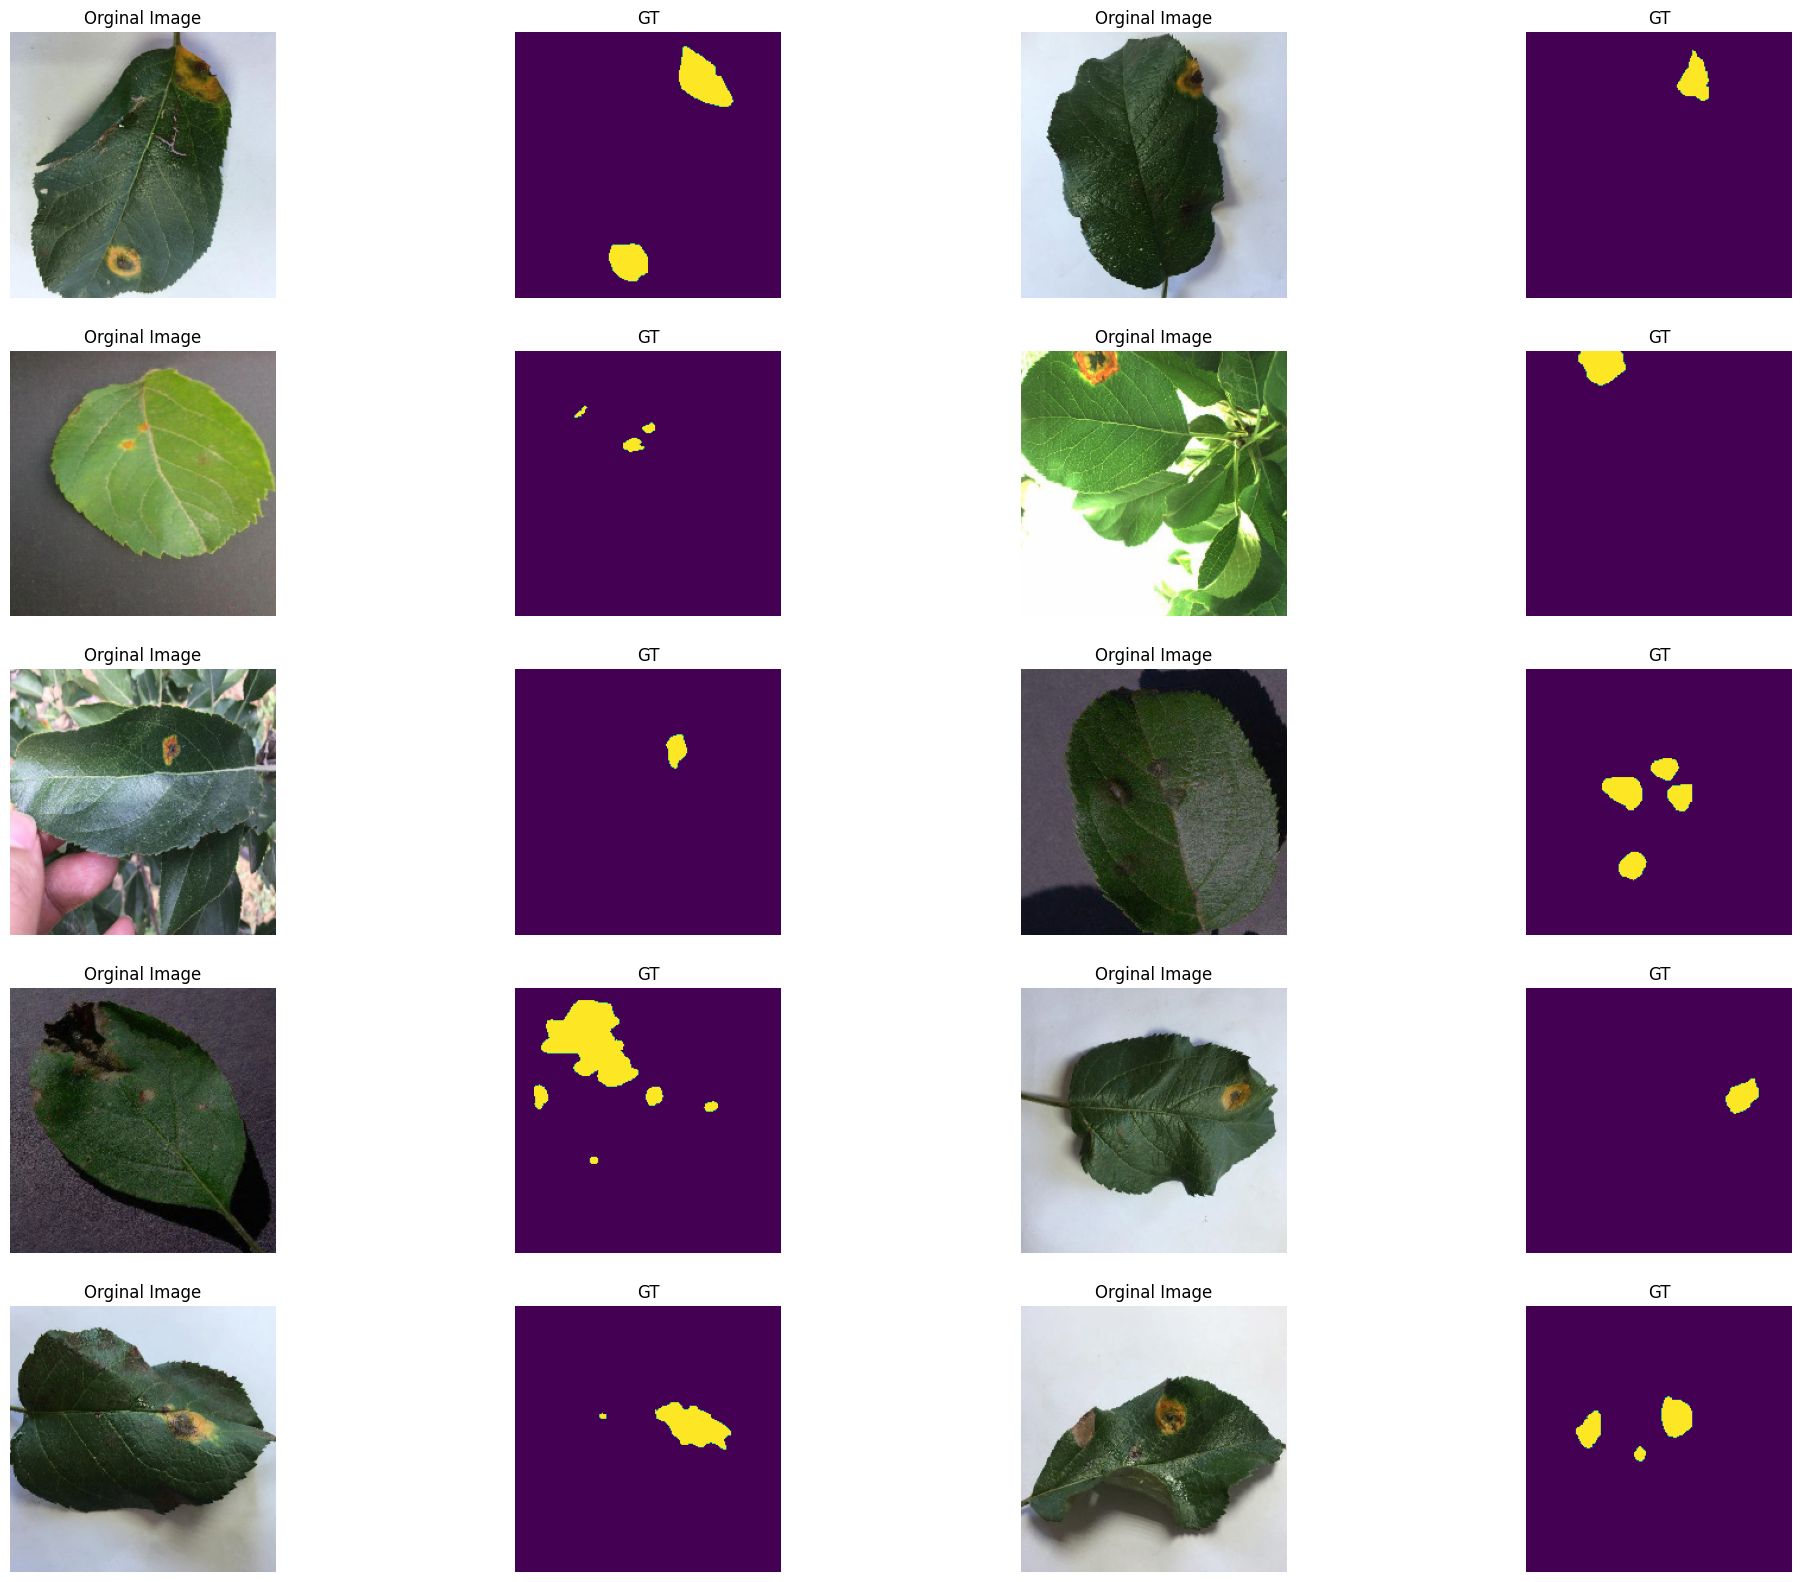

In [6]:
from matplotlib import pyplot as plt
from torchvision import transforms as T
def tn_2_np(t): 
    invTrans = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)
    
def plot(rows, cols, count, im, gt =None, title = "Orginal Image"):
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im))
    plt.axis("off")
    plt.title(title)
    return count + 1

def visualizetion(ds, im_number):
    plt.figure(figsize=(25,20))
    rows = im_number//4
    cols = im_number//rows
    count =1
    index = [random.randint(0, len(ds)-1) for _ in range(im_number)]
    
    for i, idx in enumerate(index):
        if count ==im_number+1: break
        im, gt = ds[idx]
    
        count = plot(rows, cols, count, im = im)
        count = plot(rows, cols, count, im = gt.squeeze(0), gt =True, title= 'GT')
visualizetion(ds = tr_dl.dataset, im_number= 20)

## Model

In [7]:
model = smp.Unet(encoder_name = "resnet18", classes= 2, encoder_depth = 5,
                encoder_weights = "imagenet", activation=None, decoder_channels= [256, 128, 64, 32, 16])
# model = smp.DeepLabV3Plus(classes = 2)
loss_fn = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params=model.parameters(), lr = 3e-4)
device = "cuda" if torch.cuda.is_available() else 'cpu'


In [8]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, number_class = 2):
        self.pred = torch.argmax(torch.nn.functional.softmax(pred, dim =1), dim =1)
        self.pred_ = pred
        self.gt = gt
        self.eps = eps
        self.loss_fn = loss_fn
        self.number_class = number_class

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):
        with torch.no_grad():
            pa = torch.eq(self.pred, self.gt).int()
        return float(pa.sum())/float(pa.numel())
    
    def mIoU(self):
        pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
        IoU_class = []
        for a in range(self.number_class):
            match_pred = pred ==a
            match_gt = gt == a
            if match_gt.long().sum().item() == 0: IoU_class.append(np.nan)
            else:
                intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                union = torch.logical_or(match_pred, match_gt).sum().float().item()
                iou = intersection/(union+self.eps)
                IoU_class.append(iou)
            return np.nanmean(IoU_class)
    def loss(self):
        return self.loss_fn(self.pred_, self.gt)
    

In [8]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fn, opt, seva_prefix):
        
    tr_loss, tr_pa, tr_iou = [],[],[]
    val_loss, val_pa, val_iou = [],[],[]
    # lenth of data
    tr_lens, val_lens = len(tr_dl), len(val_dl)
    best_loss = np.inf
    os.makedirs("apple_disease", exist_ok=True)
    model.to(device)
    
    print(" Train is starting .....")
    for epoch in range(epochs):
        
        tr_losses, tr_PA, tr_IOU =0,0,0
        model.train()
        
        print(f"{epoch+1} - epoch is starting ....")
        for idx, batch in enumerate(tqdm(tr_dl)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            pred = model(im)
            met = Metrics(pred, gt, loss_fn)
            loss_ = met.loss()
            
            tr_IOU += met.mIoU()
            tr_PA += met.PA()
            tr_losses += loss_.item()
            
            opt.zero_grad()
            loss_.backward()
            opt.step()
        print(f"{epoch+1} - epoch val finished:")
        model.eval()
        val_losses, val_PA, val_IOU =0,0,0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                pred = model(im)
                met = Metrics(pred, gt, loss_fn)
                val_losses += met.loss().item()
                val_PA +=met.PA()
                val_IOU +=met.mIoU()
                
        print(f"{epoch+1} - epoch result : ")
        tr_IOU /= tr_lens
        tr_PA /=tr_lens
        tr_losses /= tr_lens
        
        val_IOU /= val_lens
        val_PA /= val_lens
        val_losses /= val_lens
        
        print("\n ------------------------------------------")
        print(f"{epoch+1} - epoch train result: \n")
        print(f"Train loss                 --> {tr_losses:.3f}")
        print(f"Train PA                   --> {tr_PA:.3f}")
        print(f"Train mIoU                 --> {tr_IOU:.3f}\n")
        print(f"{epoch+1} - epoch validayion result: \n")
        print(f"Validation loss             --> {val_losses:.3f}")
        print(f"Validation PA               --> {val_PA:.3f}")
        print(f"Validation mIoU             --> {val_IOU:.3f}")
        
        tr_loss.append(tr_losses)
        tr_pa.append(tr_PA) 
        tr_iou.append(tr_IOU) 
        val_loss.append(val_losses) 
        val_pa.append(val_PA) 
        val_iou.append(val_IOU)
        if val_losses < best_loss:
            best_loss = val_losses
            print("The model with the lawest error is saved")
            torch.save(model, f"apple_disease/{seva_prefix}_best.pt")
            
    return {"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
            "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou}      
    
result= train(model = model, tr_dl = tr_dl, val_dl =val_dl, epochs = 10, device =device, loss_fn = loss_fn, opt = optimazer, seva_prefix = "apple")
        

 Train is starting .....
1 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [01:51<00:00,  5.05it/s]


1 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:15<00:00,  4.46it/s]


1 - epoch result : 

 ------------------------------------------
1 - epoch train result: 

Train loss                 --> 0.058
Train PA                   --> 0.984
Train mIoU                 --> 0.984

1 - epoch validayion result: 

Validation loss             --> 0.030
Validation PA               --> 0.989
Validation mIoU             --> 0.989
The model with the lawest error is saved
2 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:49<00:00, 11.31it/s]


2 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.59it/s]


2 - epoch result : 

 ------------------------------------------
2 - epoch train result: 

Train loss                 --> 0.026
Train PA                   --> 0.990
Train mIoU                 --> 0.990

2 - epoch validayion result: 

Validation loss             --> 0.027
Validation PA               --> 0.989
Validation mIoU             --> 0.989
The model with the lawest error is saved
3 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:49<00:00, 11.34it/s]


3 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.47it/s]


3 - epoch result : 

 ------------------------------------------
3 - epoch train result: 

Train loss                 --> 0.022
Train PA                   --> 0.991
Train mIoU                 --> 0.991

3 - epoch validayion result: 

Validation loss             --> 0.024
Validation PA               --> 0.990
Validation mIoU             --> 0.990
The model with the lawest error is saved
4 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:50<00:00, 11.22it/s]


4 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.25it/s]


4 - epoch result : 

 ------------------------------------------
4 - epoch train result: 

Train loss                 --> 0.020
Train PA                   --> 0.992
Train mIoU                 --> 0.991

4 - epoch validayion result: 

Validation loss             --> 0.023
Validation PA               --> 0.991
Validation mIoU             --> 0.991
The model with the lawest error is saved
5 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:49<00:00, 11.32it/s]


5 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.55it/s]


5 - epoch result : 

 ------------------------------------------
5 - epoch train result: 

Train loss                 --> 0.019
Train PA                   --> 0.992
Train mIoU                 --> 0.992

5 - epoch validayion result: 

Validation loss             --> 0.022
Validation PA               --> 0.991
Validation mIoU             --> 0.991
The model with the lawest error is saved
6 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:49<00:00, 11.32it/s]


6 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.47it/s]


6 - epoch result : 

 ------------------------------------------
6 - epoch train result: 

Train loss                 --> 0.017
Train PA                   --> 0.993
Train mIoU                 --> 0.993

6 - epoch validayion result: 

Validation loss             --> 0.021
Validation PA               --> 0.992
Validation mIoU             --> 0.992
The model with the lawest error is saved
7 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:50<00:00, 11.20it/s]


7 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.23it/s]


7 - epoch result : 

 ------------------------------------------
7 - epoch train result: 

Train loss                 --> 0.015
Train PA                   --> 0.994
Train mIoU                 --> 0.993

7 - epoch validayion result: 

Validation loss             --> 0.019
Validation PA               --> 0.992
Validation mIoU             --> 0.992
The model with the lawest error is saved
8 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:51<00:00, 11.05it/s]


8 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.35it/s]


8 - epoch result : 

 ------------------------------------------
8 - epoch train result: 

Train loss                 --> 0.014
Train PA                   --> 0.994
Train mIoU                 --> 0.994

8 - epoch validayion result: 

Validation loss             --> 0.020
Validation PA               --> 0.992
Validation mIoU             --> 0.992
9 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:50<00:00, 11.23it/s]


9 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:05<00:00, 12.29it/s]


9 - epoch result : 

 ------------------------------------------
9 - epoch train result: 

Train loss                 --> 0.013
Train PA                   --> 0.994
Train mIoU                 --> 0.994

9 - epoch validayion result: 

Validation loss             --> 0.020
Validation PA               --> 0.992
Validation mIoU             --> 0.992
10 - epoch is starting ....


100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [00:50<00:00, 11.08it/s]


10 - epoch val finished:


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:06<00:00, 11.67it/s]

10 - epoch result : 

 ------------------------------------------
10 - epoch train result: 

Train loss                 --> 0.014
Train PA                   --> 0.994
Train mIoU                 --> 0.994

10 - epoch validayion result: 

Validation loss             --> 0.018
Validation PA               --> 0.993
Validation mIoU             --> 0.993
The model with the lawest error is saved


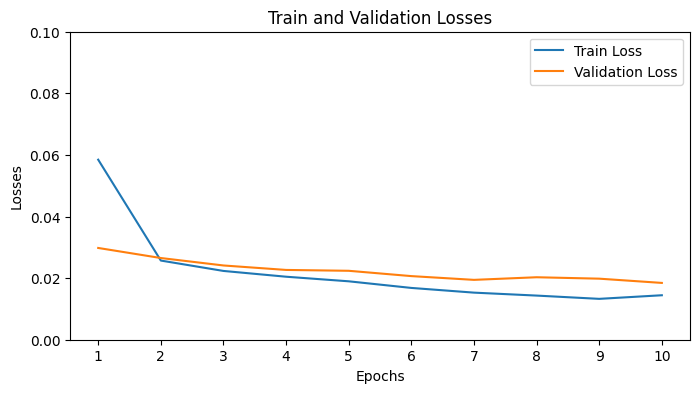

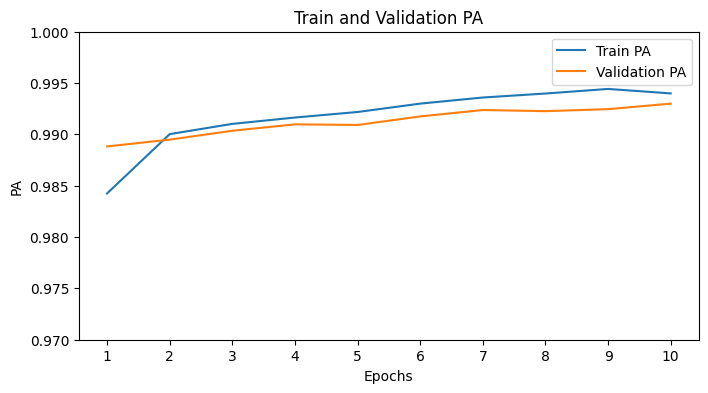

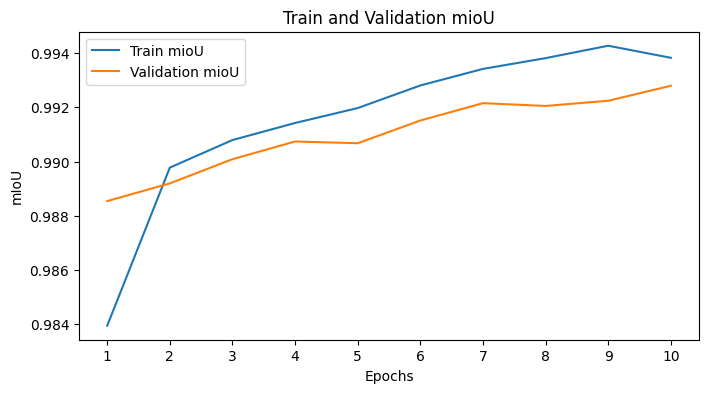

In [50]:
class plots():
    def __init__(self, r):
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_loss"], label = "Train Loss")
        plt.plot(r["val_loss"], label = "Validation Loss")
        plt.title("Train and Validation Losses")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.legend()
        plt.ylim(0, 0.1)
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(r["tr_pa"], label = "Train PA")
        plt.plot(r["val_pa"], label = "Validation PA")
        plt.title("Train and Validation PA")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("PA")
        plt.ylim(0.97, 1)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(8,4))
        plt.plot(r["tr_iou"], label = "Train mioU")
        plt.plot(r["val_iou"], label = "Validation mioU")
        plt.title("Train and Validation mioU")
        plt.xticks(np.arange(len(r["val_loss"])), [i for i in range(1, len(r["val_loss"])+1)])
        plt.xlabel("Epochs")
        plt.ylabel("mIoU")
        plt.legend()
        plt.show()
plots(result)

## Inference

  0%|                                                                                | 10/9037 [00:00<03:43, 40.31it/s]


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


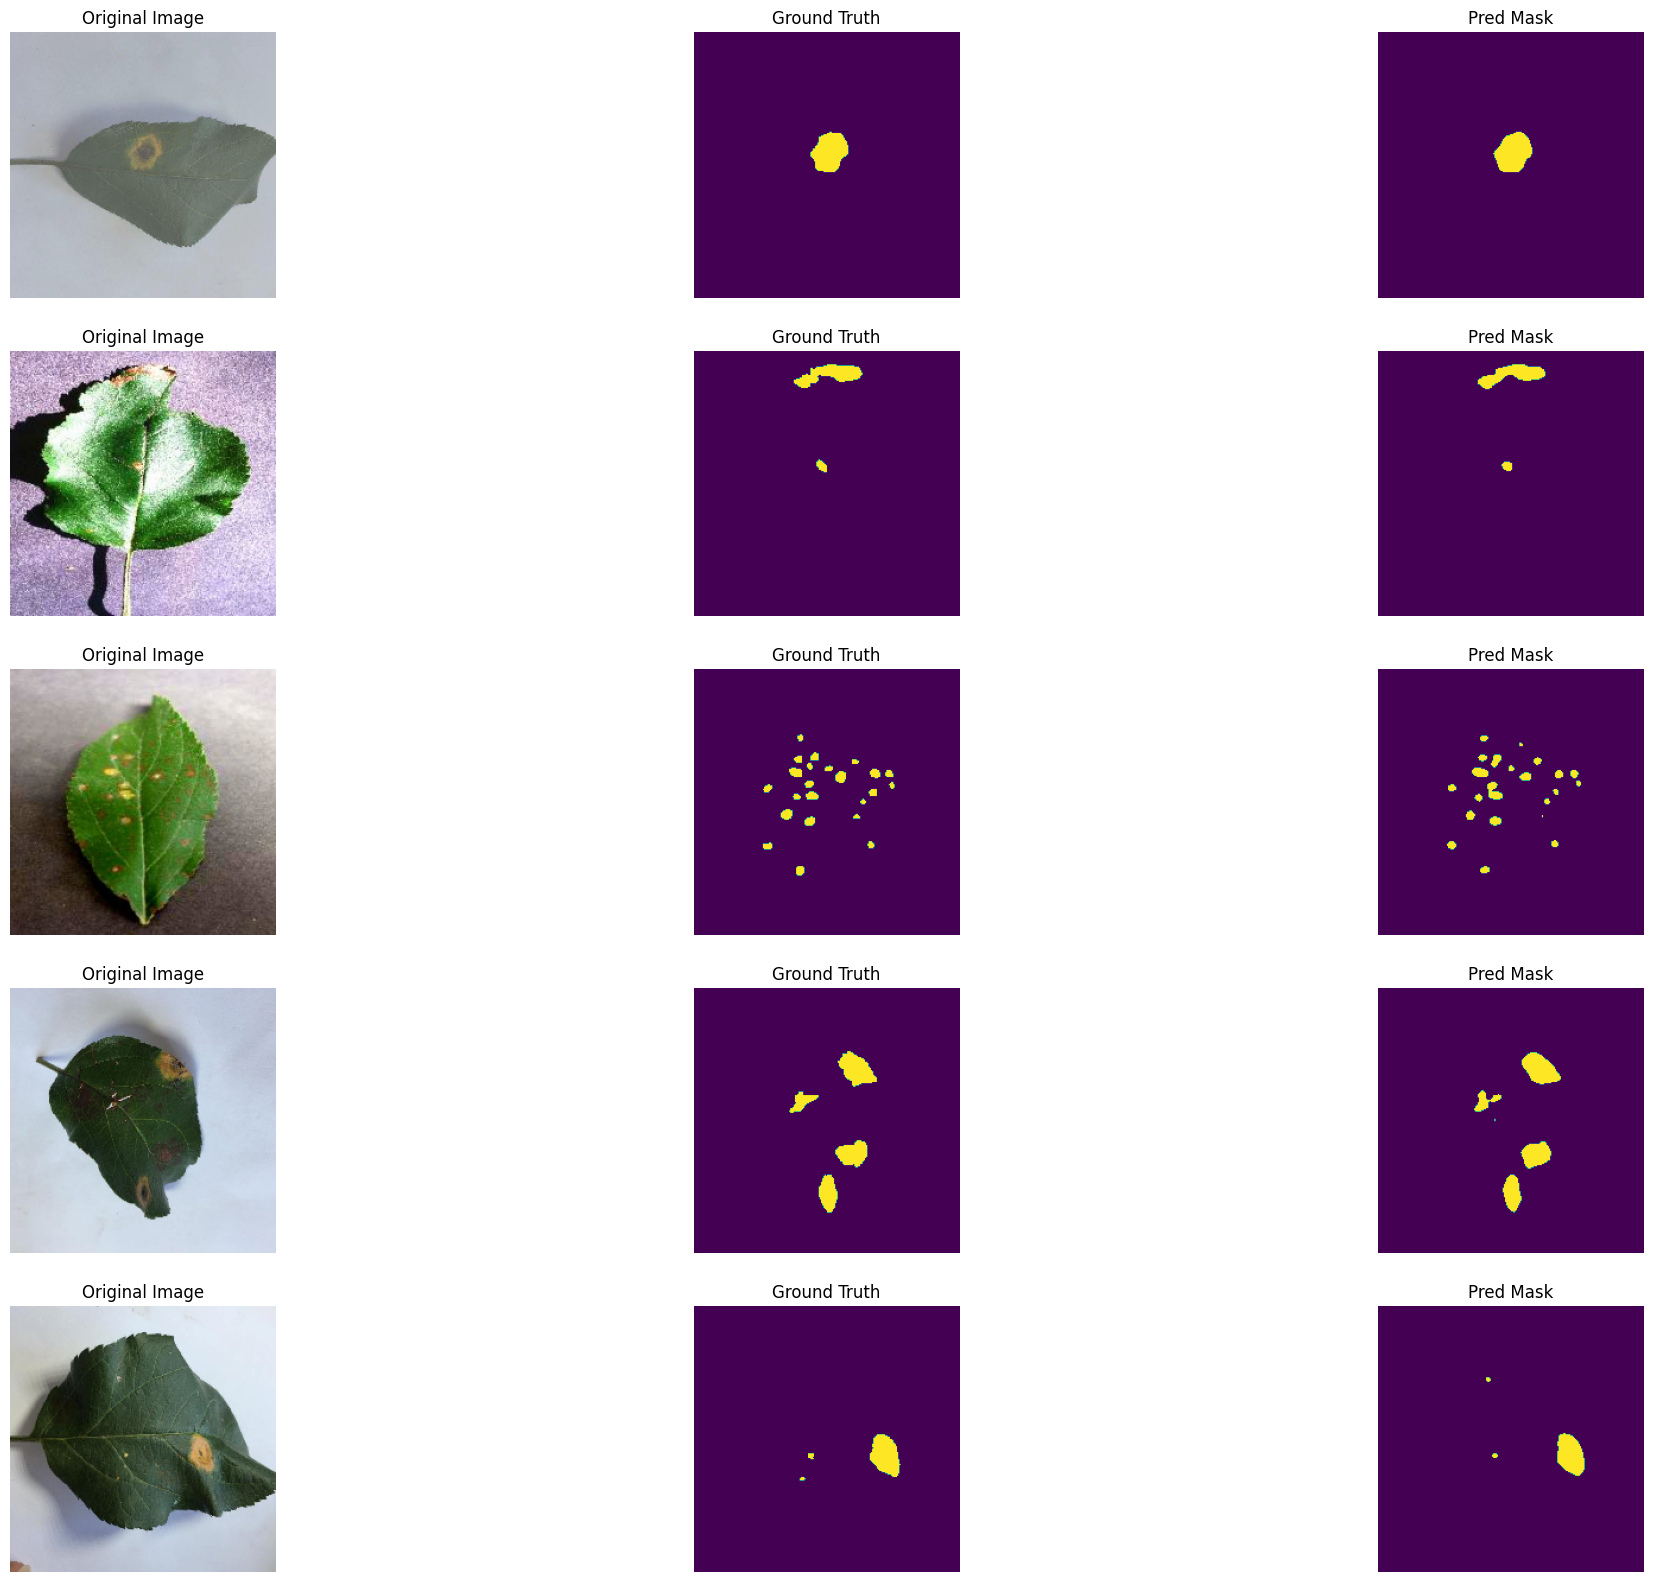

In [13]:
from tqdm import tqdm
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    return count + 1
    
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(tqdm(dl)):
        if idx == 10: break
        im, gt = data
        # print(gt.shape)

        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        print(im.shape)
            

        count = plot(cols, rows, count, im)

        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

       
        count = plot(cols, rows, count, im = pred, title = "Pred Mask")
        
model = torch.load("apple_disease/apple_best.pt")
inference(dl = ts_dl, model = model, device = device)

In [14]:
os.listdir()

['.ipynb_checkpoints',
 'apple_disease',
 'apple_disease.ipynb',
 'kaggle.json',
 'Plant disease dataset',
 'save_aerospaces_best_model']